# Intro

Machine learning focuses on making accurate predictions. But we influence the world through decisions, not predictions. Predictions can be useful inputs to improve decision-making, but models would be more valuable if they told us how to achieve our goals rather than just predicting outcomes.

Reinforcement learning aims to solve for optimal decision-making, but RL has focused more on games than on solving immediate business problems (applications in robotics being a possible exception). Moreover, most RL research intentionally avoids reliance on humans' existing domain knowledge. This may be the path towards eventual Artificial General Intelligence (AGI), but it hinders many practical applications. This notebook takes the opposite approach. 

I solve a conventional business use case that is computationally simpler than common RL applications. My approach combines RL with Structural Equation Modeling, a technique that encodes human domain knowledge into a model (typically using multiple equations that describe different parts of the domain.)

My workflow is:
1. Use structural equation modeling to create a model of the business environment. 
2. Use real data to estimate the structural model
3. Treat the estimated model as a simulation environment, and apply reinforcement learning algorithms to find an optimal the decision policy in the simulator
4. Apply that decision policy to make optimized decisions in the real business environment

This approach is labor intensive, requiring a domain expert encode their knowledge for each application to be solved. But it offers a bridge from predictions to optimal decisions in mainstream applications where we currently use ML.

# Example Use Cases

### Airline Pricing
Airlines use machine learning models to help set ticket prices. A model predicts how many tickets the airline can sell each day for each upcoming flight for each candidate price. The models consider price, seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model doesn't guarantee efficient price setting.

For example, consider a flight happening in 100 days which currently has 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose? 

Airlines currently convert predictive models into pricing decisions with heuristics (e.g. a timetable of how many tickets to sell at pre-specified periods before the flight, or a goal of selling up to a pre-specified demand elasticity.)

### Grocery Store Logistics
A grocery chain ran a [predictive modeling competition on Kaggle](https://www.kaggle.com/c/favorita-grocery-sales-forecasting) to improve demand forecasts. They aimed to stock match their purchases from wholesales to their retail sales. However, the predicted sales is not always the optimal amount to stock.

If you purchase exactly the amount you are predicted to sell, you will experience frequent stockouts (when your model underestimates demand), reducing sales volume and disappointing customers.  Similarly, some items will spoil when predicted sales exceed actual sales. Unless the model is exactly correct every time, you face a tradeoff.  The optimal decision would consider factors like
- Markup rate on each item
- Spoilage rate
- Cost of storage
- Value of ensuring customers find the items they want
- etc.

In practice, grocery store managers likely guess at how to make these tradeoffs, much as they may have guessed at how much of each food they would sell before adopting ML. But the approach in this notebook would help them make better decisions.


# Implemention Overview
This notebook focuses on the Airline Pricing example.

I simulate a data generating process for how the market works rather than using real data. This makes it easier to illustrate the benefits of decision optimization because we can easily visualize how each pricing strategy performs in the original data generating environment.

## Market Set-Up
For illustrative simplicity, this example considers a market with only two airlines. We train an agent to set prices for Jetblue; the competitor, whose prices we cannot control, is called Delta. 

There are two types of information:
1. Information and processes that are known to the airline (such as the number of seats on each flight, days remaining before takeoff, etc.).
2. Information and processes that aren't directly know to the airlines (their competitor's pricing policy, and the exact demand for tickets on each day). 

The airline builds a model to predict factors they don't directly observe. Processes they don't directly observe are stored in a `CompetitiveConditions` object. When simulating data the real environment, I build a `CompetitiveConditions` from the true data generating process. When optimizing pricing, the airline use a `CompetitiveConditions` object based on their predictive model.

The other important class in the following code is the `Market`. A `Market` object holds some `CompetitiveConditions` as well as all information that airlines can directly observe. 

`Market` follows the OpenAI Gym API. So we can apply standard reinforcement learning tools to optimize the pricing policy from our model based environment.

# Step 1: Collect Data From Real Market

We define some parameters and import a function that determine the true data generating process. The exact market mechanisms (which the constants below affect) aren't central to the optimization workflow. So a description of the market details is postponed to the bottom of this notebook.

For now, you can safely treat the quantity-determining mechanism and it's parameters as a black box, much as the airlines do.

In [1]:
import altair as alt
import numpy as np
import pandas as pd

from true_dgp import get_true_qty_demanded_fn

# Constants hidden from airlines
CUSTOMER_LEVEL_RANDOMNESS = 20
DEMAND_SIGNAL_NOISINESS = 10
MAX_DEMAND_LEVEL = 400
POTENTIAL_CUSTOMERS_PER_DAY = 20

# Constants known to airlines
SEATS_PER_FLIGHT = 250
SALES_WINDOW_LENGTH = 120


I used trial and error to find a reasonable pricing function. I use the following function for both airlines when creating "real" data.

In [2]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, if few seats are available, or if you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    formula_price = 50 + my_demand_signal + 0.6 * days_before_flight - my_seats_avail + 40 * int(competitor_full)
    # demand_signal is noisy and can thus be negative. Never price tickets below some price_floor
    price_floor = 10
    actual_price = max(formula_price, price_floor)
    return actual_price


# Run Real Market

Airlines have historical data they can use to build a model. Here, we run the "real" environment to create this data.

In [3]:
from market import Market
from market_conditions import CompetitiveConditions
from model_testing import run_env


real_market_conditions = CompetitiveConditions(delta_price_fn = simple_price_fn, 
                                               qty_fn=get_true_qty_demanded_fn(POTENTIAL_CUSTOMERS_PER_DAY, CUSTOMER_LEVEL_RANDOMNESS))

real_market = Market(real_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=1000)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=20)


# Step 2: Fit Machine Learning Model on Real Data

We fit a model that predicts Delta's price and the quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)


In [4]:
from keras_models import get_keras_model, prep_for_keras_model

train_x, train_y = prep_for_keras_model(train_data)
val_x, val_y = prep_for_keras_model(val_data)
keras_model = get_keras_model(train_x, train_y, val_x, val_y, verbose=0)

# Step 3: Set Up Model-Based Market Simulator

Now we create a market based not on the true data generating processes (which the firms don't know), but instead based on the predictive model.

As a diagnostic, I compare predicted profits from using Jetblue's current pricing function in the training, validation and simulator data.

There are important dynamics from outside the ML model used here.

**TODO: DESCRIPTION OF STRUCTURAL EQUATION MODEL**

In [5]:
sim_market_conditions = CompetitiveConditions(keras_model=keras_model)
# use function returning simulated market with baselines API to facilitate parallelism
sim_market_maker = lambda: Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)
noisy_sim_market_maker = lambda: Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH, summarize_on_episode_end=True)
sim_market = sim_market_maker()


simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=20)

print("Mean profits in training data: {} \n"
      "Mean profits in val data: {} \n"
      "Mean profits in sim data: {} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

Mean profits in training data: 41668.75140000001 
Mean profits in val data: 40494.08 
Mean profits in sim data: 46503.44 



# Diagnostics and Experiment With Different Pricing Strategies

Now that we have a simulator, we could apply an arbitrary reinforcement learning algorithm to create a better pricing policy. While we use the simulator for learning, our goal is to have a pricing policy that increases profits in the real environment.

For simplicity, we start with something simpler than an arbitrary reinfrocement learning model. That is, we have a function `pricing_fn_maker` that returns the previously used pricing function by some constant. This would conceivably correct for systematic overpricing or underpricing in the original pricing function.

   base_price_mult  mean_predicted_rev  mean_actual_rev
0             0.50          25982.9850       28275.3800
1             0.75          39804.6675       41413.7250
2             1.00          43850.4800       41369.2300
3             1.25          45095.2125       20446.3375
4             1.50          33636.6750       12554.4750


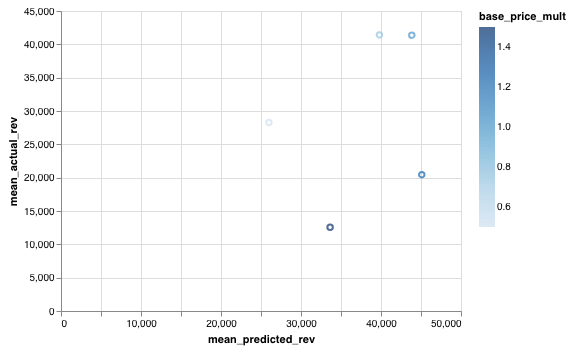

In [6]:
def pricing_fn_maker(baseline_price_multiplier):
    def new_price_fn(*args, **kwargs):
        return baseline_price_multiplier * simple_price_fn(*args, **kwargs)
    return new_price_fn

alternative_pricing_profits = []
alternative_pricing_scenario_details = {}

for price_mult in [0.5, 0.75, 1, 1.25, 1.5]:
    new_price_fn = pricing_fn_maker(price_mult)
    pred_profits, pred_data = run_env(sim_market, new_price_fn, n_times=20)
    actual_profits, actual_data = run_env(real_market, new_price_fn, n_times=20)
    alternative_pricing_profits.append((price_mult, pred_profits.mean(), actual_profits.mean()))
    alternative_pricing_scenario_details[price_mult] = {'pred': pred_data,
                                                        'actual': actual_data}

price_comparison = pd.DataFrame(alternative_pricing_profits, 
                                columns=['base_price_mult', 'mean_predicted_rev', 'mean_actual_rev'])

print(price_comparison)

alt.Chart(price_comparison).mark_point().encode(
    x='mean_predicted_rev',
    y='mean_actual_rev',
    color='base_price_mult',
    tooltip='base_price_mult')

At the current sample sizes (chosen to reflect what we collect have access to in practice), there is still some noise in the model.

Below, I show predicted quantities sold in a given day for various candidate jetblue prices (holding the number of days until the flight and Jetblue's demand signal constant.)

In [7]:
days_before_flight = jb_demand_signal = 150
pred_outcomes_diff_jb_prices = []
for jb_price in np.linspace(0, MAX_DEMAND_LEVEL, 6):
    # Some extra munging here do to messiness associated with multi-input / multi-output model.
    # each input fed in as separate array to facilitate hiding jetblue_price from prediction of delta_price
    prediction_data = prep_for_keras_model([days_before_flight, jb_demand_signal, jb_price], skip_y=True)
    prediction = keras_model.predict(prediction_data)
    delta_price, jb_seats_sold, delta_seats_sold = [i[0][0] for i in prediction]
    pred_outcomes_diff_jb_prices.append({'jb_price': jb_price,
                                         'delta_price': delta_price,
                                         'jetblue_seats_sold': jb_seats_sold,
                                         'delta_seats_sold': delta_seats_sold})
pd.DataFrame(pred_outcomes_diff_jb_prices).set_index(['jb_price'])

,delta_price,delta_seats_sold,jetblue_seats_sold
jb_price,,,
0.0,171.45694,13.142011,13.985651
80.0,171.45694,8.162297,8.579861
160.0,171.45694,4.896030,5.297741
240.0,171.45694,0.644833,0.588359
320.0,171.45694,0.348819,0.285316
400.0,171.45694,0.089007,0.170112


It's reassuring that delta price is independent of **jb_price**. Delta must choose their price without seeing Delta's.  However, it's a shortcoming of the model that Delta is predicted to sell fewer seats as jetblue's price increases.

Even with shortcomings in the model, we can optimize a pricing policy against the model and find it improves profits in the real environment.

# Step 4: Optimize Policy Function
Everything below is currently in-progress. Looking at RL with the `stable_baselines` library, which is a better-maintained fork of OpenAI baselines.

In [12]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.sac.policies import MlpPolicy
from stable_baselines.sac import SAC
from time import time
import os

parallelism_level = 1         # use os.cpu_count() if not using SAC. SAC doesn't allow parallelism
env = DummyVecEnv([sim_market_maker for _ in range(parallelism_level)]) # Env is vectorized market for parallelism

model = SAC(MlpPolicy, env)

def evaluate(model, num_episodes):
  episode_rewards = [0.0]
  obs = env.reset()
  num_steps = num_episodes * SALES_WINDOW_LENGTH - 1
  for i in range(num_steps):
      action, _ = model.predict(obs)
      # action, rewards and dones are arrays because we are using vectorized env
      obs, rewards, dones, _ = env.step(action)
      episode_rewards[-1] += rewards[0]
      
      if dones[0]:
          obs = env.reset()
          episode_rewards.append(0.0)
  assert len(episode_rewards) == num_episodes
  return round(np.mean(episode_rewards))


start_time = time()
for num_updates in range(1, 10):
    model.learn(total_timesteps=20000)
    mean_reward = evaluate(model, num_episodes=2)
    print("""{} learn calls executed in {:.0f} seconds. Current score in sim: {:.0f}""".format(num_updates, time()-start_time, mean_reward))

1 learn calls executed in 158 seconds. Current score in sim: 28200
2 learn calls executed in 315 seconds. Current score in sim: 26400
3 learn calls executed in 472 seconds. Current score in sim: 25400
4 learn calls executed in 629 seconds. Current score in sim: 24400
5 learn calls executed in 787 seconds. Current score in sim: 26200
6 learn calls executed in 945 seconds. Current score in sim: 22600
7 learn calls executed in 1103 seconds. Current score in sim: 27000
8 learn calls executed in 1260 seconds. Current score in sim: 25200
9 learn calls executed in 1418 seconds. Current score in sim: 25000


## Details

#### How The Market Works
Some number of customers (`POTENTIAL_CUSTOMERS_PER_DAY`) come to a website each day.  The customers' average willingness to pay for a flight on that day `demand_level`. The `demand level` on any given day is chosen from a distribution `uniform(0, MAX_DEMAND_LEVEL)`.  Each airline receives a signal about `demand_level` on that day, and the signal is the `demand_level` plus some noise that is distributed `N(0, DEMAND_SIGNAL_NOISINESS)`. This demand signal might represent a prediction of demand from a model considering seasonality, macroeconomics, etc. Additionally, each customer has idiosyncratic preferences, so their willingness to pay for a ticket on any given airline is `demand_level + customer_preference` where `customer_preference` is distributed `N(0, CUSTOMER_LEVEL_RANDOMNESS)`.  The customer considers the price for each of the two airlines and purchases a ticket from the airline that gives them the highest consumer surplus (their personal willingness to pay minus for a ticket on that airline minus the cost of a ticket on that airline).  If the customer's consumer surplus for both airlines is negative, they do not buy a ticket.
